# **Import**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization

# GPU CONFIGURATION
from tensorflow.config.experimental import list_physical_devices, set_virtual_device_configuration, VirtualDeviceConfiguration, get_device_details
gpus = list_physical_devices('GPU')
print(len(gpus), "Physical GPUs:", get_device_details(gpus[0])['device_name'])
set_virtual_device_configuration(gpus[0], [VirtualDeviceConfiguration(memory_limit=1400)])

1 Physical GPUs: NVIDIA GeForce MX250


# **Data**

In [2]:
def sinus(x, A, w, t0):
    sinus = A * np.sin(x/w + t0)
    return sinus

def sinus_exp(x, A, w, t0, B, alfa, c0):
    sinus = A * np.sin(x/w + t0)
    exp = B * np.exp(alfa*x + c0)
    return sinus * exp

def sinus_cosinus(x, A, w, t0, B, w2, t02):
    sinus = A * np.sin(x/w + t0)
    cosinus = B * np.cos(x/w2 + t02)
    return sinus * cosinus

(6000,)


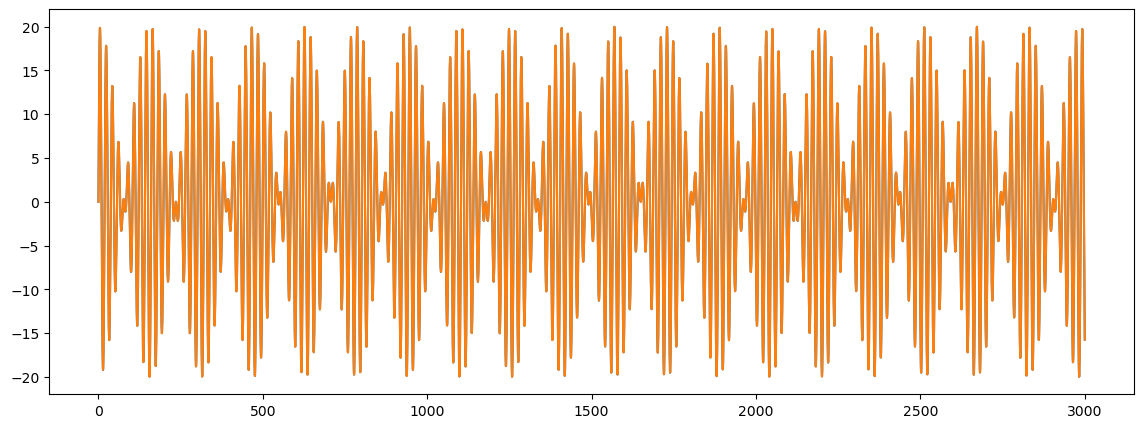

In [3]:
res = 0.5
tmax = 3000
N = int(tmax / res)
t = np.linspace(0, tmax, N)

# data = sinus_exp(t, A=20, w=3, t0=10, B=1, alfa=0.005, c0=0)
data = sinus_cosinus(t, A=20, w=3, t0=0, B=1, w2=50, t02=0)

noise = np.random.normal(0, 0.01, size=N)

plt.figure(figsize=(14,5))
plt.plot(t, data+noise)
plt.plot(t, data)

data = data+noise

print(data.shape)

## **Prepare training arrays**

We will cut data into array of length 20 and use 21-th element as labels.

```
data[i:i+20] -> X
data[20] -> y
```

In [6]:
N2 = 200

X = np.array([data[i:i+N2] for i in range(N-N2)]).reshape(-1, N2, 1)
y = np.array([data[i+N2] for i in range(N-N2)])
X.shape, y.shape

((5800, 200, 1), (5800,))

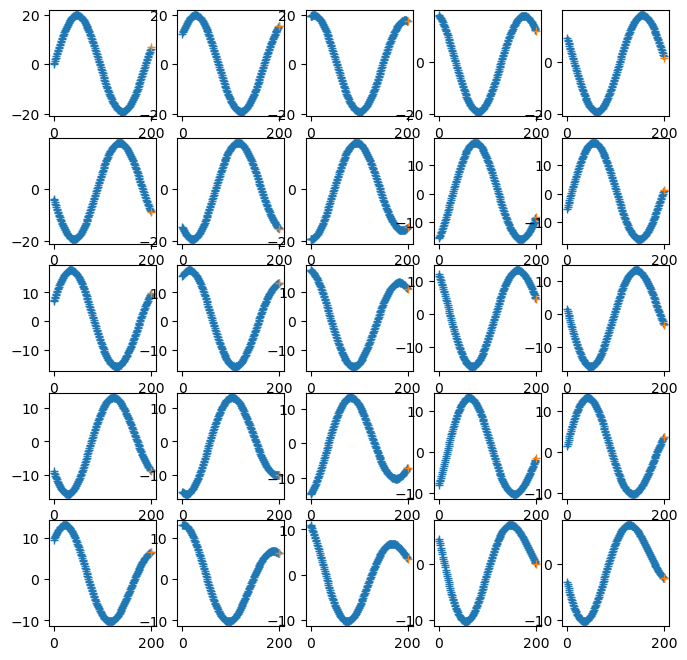

In [5]:
fig, axs = plt.subplots(5,5,figsize=(8,8))
n = 0
for i in range(5):
    for j in range(5):
        axs[i,j].plot(X[n], marker="+")
        axs[i,j].plot(N2, y[n], "+")
        n += 20

In [6]:
X = StandardScaler().fit_transform(X.reshape(-1, N2)).reshape(-1, N2, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5) 

print(X.shape, y.shape)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(19800, 200, 1) (19800,)
(15840, 200, 1) (15840,) (1980, 200, 1) (1980,) (1980, 200, 1) (1980,)


# **Model**

In [4]:
model = Sequential()
# model.add(BatchNormalization())
model.add(LSTM(128, activation='tanh'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mse')

## **Fitting**

Epoch 1/10
100/100 [==============================] - 29s 278ms/step - loss: 21.3745
Epoch 2/10
100/100 [==============================] - 26s 265ms/step - loss: 0.0270
Epoch 3/10
100/100 [==============================] - 26s 256ms/step - loss: 0.0069
Epoch 4/10
100/100 [==============================] - 29s 288ms/step - loss: 0.0044
Epoch 5/10
100/100 [==============================] - 25s 252ms/step - loss: 0.0029
Epoch 6/10
100/100 [==============================] - 25s 246ms/step - loss: 0.0016
Epoch 7/10
100/100 [==============================] - 29s 293ms/step - loss: 0.0039
Epoch 8/10
100/100 [==============================] - 25s 255ms/step - loss: 0.0033
Epoch 9/10
100/100 [==============================] - 27s 265ms/step - loss: 0.0020
Epoch 10/10
100/100 [==============================] - 28s 281ms/step - loss: 0.0030


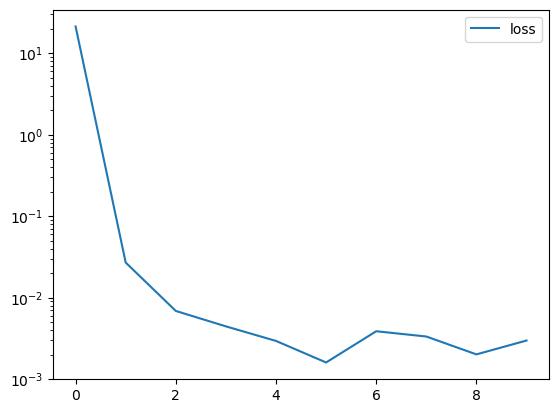

In [5]:
def data_generator(bs, Nmin, Nmax, N):
    while True:
        N2 = np.random.randint(Nmin, Nmax)
        t0s = np.random.randint(0, N-N2, size=bs)
        X = np.array([data[t0:t0+N2] for t0 in t0s]).reshape(-1, N2, 1)
        y = np.array([data[t0+N2] for t0 in t0s])
        yield X, y

history = model.fit(data_generator(128, 200, 2000, N),
                    # X_train, y_train,
                    # validation_data=(X_val, y_val),
                    # batch_size=10, 
                    steps_per_epoch=100, epochs=10, verbose=1)

plt.plot(history.history['loss'], label="loss")
# plt.plot(history.history['val_loss'], label="val_loss")
plt.yscale("log")
plt.legend(loc="upper right")
plt.show()

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 70,721
Trainable params: 70,721
Non-trainable params: 0
_________________________________________________________________


## **Prediction**

In [ ]:
y_pred = model.predict(X)

# plt.plot(t, data+noise)
# plt.plot(t, )

plt.plot(data[N2:]+noise[N2:], label="data")
plt.plot(y_pred, label="prediction")

## **Extrapolate**

In [7]:
N2 = 800
Next = 800
X0 = data[-N2:]
y_pred0 = []
for i in range(Next):
    pred = model.predict(X0.reshape(1,N2,1))[0,0]
    y_pred0.append(pred)
    X0 = np.concatenate((X0[1:], [pred]))

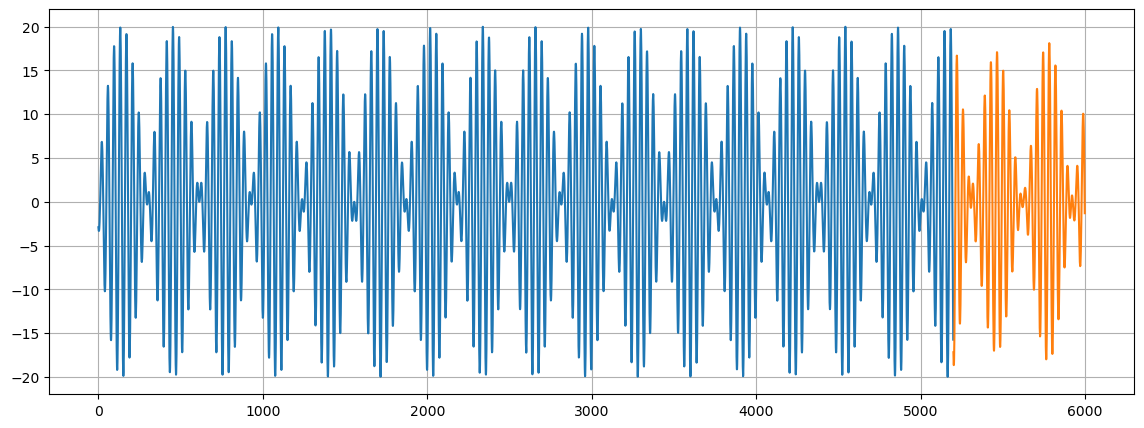

In [8]:
plt.figure(figsize=(14,5))
plt.plot(data[N2:], label="data")
# plt.plot(y_pred, label="prediction")
plt.plot(np.arange(N-N2,N-N2+Next), y_pred0, label="extrapolation")
plt.grid()
# plt.legend()

## **Bin & extrapolate**

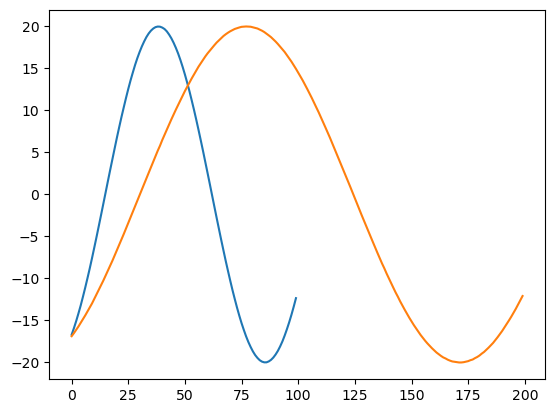

In [211]:
X0 = data[-N2*2:].reshape(N2,2).mean(axis=1)
plt.plot(X0)
plt.plot(data[-N2*2:])

In [212]:
Next = 500
X0 = data[-N2*2:].reshape(N2,2).mean(axis=1)
y_pred0 = []
for i in range(Next):
    pred = model.predict(X0.reshape(1,N2,1))[0,0]
    y_pred0.append(pred)
    X0 = np.concatenate((X0[1:], [pred]))

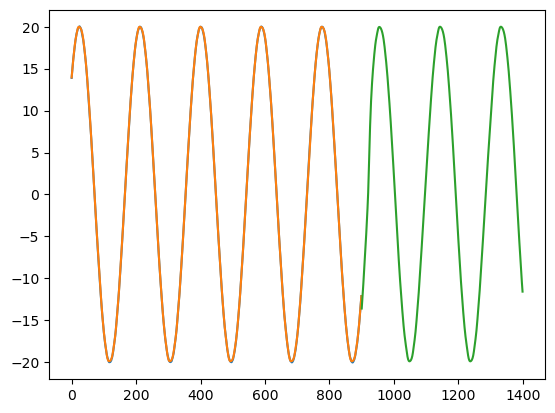

In [213]:
plt.plot(data[N2:], label="data")
plt.plot(y_pred, label="prediction")
plt.plot(np.arange(N-N2,N-N2+Next), y_pred0, label="extrapolation")
# plt.legend()

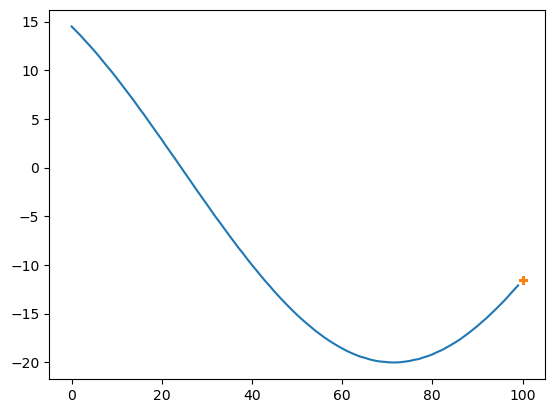

In [216]:
preds = []
for i in range(100):
    preds.append(model.predict(data[-N2-i:].reshape(1,-1))[0][0])

plt.plot(data[-N2:])
plt.plot(np.ones(100)*100, preds, "+")

# **Various lenghts**

In [231]:
def random_split(N, lmin, lmax):
    N2 = []
    while sum(N2) < N:
        number = np.random.randint(lmin, lmax)
        if (sum(N2) + number) < N: N2.append(number)
        else: N2.append(N - sum(N2))
    return N2

def 

In [230]:
for i in range(5):
    N2 = random_split(N, 50, 150)
    for j in range(len(N2)-1):
        print(N2[j], N2[j+1])
        print(data[N2[j]:N2[j+1]])
    # X = [data[N2[i]:N2[i+1]] for i in range(len(N2)-1)]
    # y = [data[N2[i+1]] for i in range(len(N2)-1)]

0 98
[-10.86683997 -11.45575617 -11.97380858 -12.51317933 -13.0251744
 -13.51651891 -14.0064644  -14.47208965 -14.91993869 -15.3589495
 -15.77136326 -16.18825274 -16.56601086 -16.92298357 -17.27413154
 -17.61074861 -17.89807121 -18.20054869 -18.4427094  -18.7177148
 -18.91491572 -19.14553723 -19.32060986 -19.47658616 -19.61981625
 -19.73447455 -19.82750579 -19.90639888 -19.94756625 -20.00014045
 -20.01868526 -20.00835546 -19.95005513 -19.88205645 -19.79858864
 -19.71374278 -19.57703624 -19.43533857 -19.25124263 -19.07378317
 -18.86550402 -18.63640933 -18.36421102 -18.09645702 -17.81183289
 -17.5061447  -17.14911758 -16.81396572 -16.44032256 -16.04582051
 -15.6418333  -15.20465377 -14.77931677 -14.32504486 -13.8593776
 -13.36197587 -12.85276498 -12.33594909 -11.82163594 -11.26288282
 -10.71011609 -10.12462489  -9.5566392   -8.94709949  -8.34970036
  -7.75182776  -7.10265254  -6.48894026  -5.86273377  -5.21191852
  -4.56980329  -3.92803269  -3.27698333  -2.6133064   -1.93634062
  -1.2810

In [222]:
X

[array([-10.88163781, -11.44215198, -11.97786817, -12.49706717,
        -13.02492558, -13.51877437, -13.99694986, -14.46390206,
        -14.91438192, -15.33700936, -15.74860826, -16.17511109,
        -16.55025793, -16.94304103, -17.27001032, -17.60444009,
        -17.91485667, -18.18787994, -18.47729754, -18.69641919,
        -18.91857412, -19.15794763, -19.31576588, -19.48050378,
        -19.63574204, -19.74421645, -19.84297424, -19.92103039,
        -19.97501318, -20.00245109, -20.00056298, -19.98870354,
        -19.95435636, -19.88441128, -19.81228701, -19.70303402,
        -19.57228181, -19.42389754, -19.25260256, -19.07082008,
        -18.86017681, -18.64949351, -18.37320864, -18.09417017,
        -17.80235165, -17.49010697, -17.17008321, -16.83265521,
        -16.44094125, -16.04779305, -15.62340115, -15.20267828,
        -14.77794595, -14.32241443, -13.83504895, -13.36603509,
        -12.84442085, -12.33815509, -11.80569966, -11.24849971,
        -10.71349257]),
 array([], dtype